# Notebook 3b: Modeling with Recurrent Neural Networks

For patch updates, I will be using a Reccurent Neural Network to predict when future patches will come out. Neural Networks are black box models, though, so I will not be able to interpret why they are or aren't working. I expect, through trends in sentiment, comment count, and other meta data, as well as usage of my own self vectorized words, that it will predict decently. In an effort to figure out the features that work best, I will be using all of the meta data I created and gathered, the words I vectorized myself, as well as components created using Principal Component Analysis on the 2000 countvectorized features. 

If the RNN does work as planned, this model can be used as a guide for game companies to track user feedback online in between patches and guide patch updates with respect to how users are feeling about certain aspects of the game at a given time. If there are consistent complaints regarding certain game modes, characters, perks, weapons, etc., the company can focus on fixing these before implementing new things. 


In [266]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, LSTM
from keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator
import keras
%matplotlib inline

In [267]:
df_daily = pd.read_csv('../data/df_daily.csv', index_col = 'date')

In [268]:
df_most_common_words = pd.read_csv('../data/most_common_words_cvec.csv')

In [269]:
df_most_common_words.drop('Unnamed: 0', axis = 1, inplace = True)

Setting my vectorized index to the dates each word occurred on. 

In [270]:
df_most_common_words.index = df_daily.index

In [271]:
df_daily.index = pd.to_datetime(df_daily.index)

## RNN with OP Words

Setting my X and y.

In [272]:
df_daily.patch_update.value_counts(normalize = True)

0.0    0.91133
1.0    0.08867
Name: patch_update, dtype: float64

In [273]:
X = df_daily.drop(columns = ['patch_update', 'created_utc', 'body'])
X.head()

,score,compound,character_count,word_count,interaction_score_compound,count_comments,op,nerf,perk,over,...,quit,auto,noob,range,rate,fire,compound_sum,unique_authors,interaction_sum,comment_count
date,,,,,,,,,,,,,,,,,,,,,
2018-10-11,44081,0.179693,1358543.0,256354,0.603192,11418,572.0,23.0,28.0,408.0,...,61.0,39.0,29.0,37.0,143.0,59.0,2051.7369,4237,6887.2453,11418
2018-10-12,70759,0.143451,2415905.0,454034,0.511025,19114,1294.0,68.0,128.0,675.0,...,146.0,79.0,29.0,167.0,341.0,173.0,2741.9244,8202,9767.7377,19114
2018-10-13,66467,0.095393,2288630.0,431604,0.229019,15688,1148.0,140.0,126.0,652.0,...,147.0,99.0,33.0,352.0,348.0,225.0,1496.5304,7089,3592.8498,15688
2018-10-14,65811,0.078420,2568833.0,484629,0.171104,17227,1308.0,181.0,133.0,743.0,...,165.0,90.0,49.0,390.0,427.0,359.0,1350.9338,7771,2947.6086,17227
2018-10-15,79944,0.079358,3053849.0,575691,0.115871,19823,1524.0,174.0,203.0,898.0,...,200.0,120.0,55.0,448.0,507.0,462.0,1573.1210,8220,2296.9086,19823


In [274]:
y = df_daily['patch_update']

Train test splitting my data so I can train my model and check how well it works on the validation set. I will be setting 'shuffle' to False because I am using timeseries data and want my split to be after 75% of the dataset, not a random 75% of the dataset. 

Setting my y variable to a categorical numpy array. 

In [275]:
#y = keras.utils.to_categorical(y, num_classes=None, dtype='float32')

In [276]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    shuffle = False,
                                                    random_state = 13)

Scaling my data. It is necessary for my RNN model. 

In [277]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

/Users/adamburpee/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/adamburpee/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/adamburpee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


Setting my train and test sequences. I played around with the length and batch size and this seems to be the combination that works the best. I am setting my testing batch size to 50 because there aren't 100 samples in the testing set. 

In [278]:
train_sequences = TimeseriesGenerator(X_train_sc,
                                      y_train,
                                      length = 7,
                                      batch_size = 100)

In [279]:
test_sequences = TimeseriesGenerator(X_test_sc, 
                                     y_test,
                                     length = 7,
                                     batch_size = 50)

In [280]:
X_train.shape

(152, 34)

Instantiating my model.

In [281]:
model = Sequential()


I am using an input GRU layer, with 4 hidden layers, one of which is a dropout layer. I messed around with different different node numbers, and these seemed to work well. The standard is to use powers of 2, but I found that 36 on my first hidden layer worked well. I will be using relu activation for my hidden layers, and a sigmoid activation for my output. This will be standard throughout the notebook.

In [282]:
model.add(GRU(32,
              input_shape = (7,34),
              return_sequences = True))

model.add(GRU(36,
              return_sequences = False))

# model.add(GRU(18,
#               return_sequences = False))

model.add(Dense(16,
                activation = 'relu'))

model.add(Dropout(0.5))

model.add(Dense(16,
                activation = 'relu'))

#model.add(Dropout(0.5))

model.add(Dense(1,
                activation = 'sigmoid'))

Compiling my model with a binary_crossentropy loss function because I am dealing with binary classification. 

In [283]:
model.compile(loss = 'binary_crossentropy',
#               optimizer = 'sgd',
              optimizer = Adam(lr = .0006),
              metrics = ['accuracy'])

Fitting and generating my results. I will be focusing on accuracy, as I am most concerned with optimizing when my predictions are correct. I am not focused on false positives or false negatives for this analysis. 

In [284]:
history = model.fit_generator(train_sequences,
                              epochs = 25,
                              validation_data = test_sequences,
                              verbose = 1)

Epoch 1/25
2/2 [==============================] - 8s 4s/step - loss: 0.6559 - acc: 0.7600 - val_loss: 0.6093 - val_acc: 0.8636
Epoch 2/25
2/2 [==============================] - 0s 18ms/step - loss: 0.6367 - acc: 0.7978 - val_loss: 0.5833 - val_acc: 0.8636
Epoch 3/25
2/2 [==============================] - 0s 62ms/step - loss: 0.6143 - acc: 0.8204 - val_loss: 0.5565 - val_acc: 0.8636
Epoch 4/25
2/2 [==============================] - 0s 48ms/step - loss: 0.5821 - acc: 0.8582 - val_loss: 0.5314 - val_acc: 0.8636
Epoch 5/25
2/2 [==============================] - 0s 50ms/step - loss: 0.5555 - acc: 0.8623 - val_loss: 0.5077 - val_acc: 0.8636
Epoch 6/25
2/2 [==============================] - 0s 53ms/step - loss: 0.5458 - acc: 0.9017 - val_loss: 0.4831 - val_acc: 0.8636
Epoch 7/25
2/2 [==============================] - 0s 57ms/step - loss: 0.5372 - acc: 0.8961 - val_loss: 0.4637 - val_acc: 0.8636
Epoch 8/25
2/2 [==============================] - 0s 52ms/step - loss: 0.5141 - acc: 0.9074 - val_l

Examining the ratio of target class to non target class in the training and testing sets to compare my accuracy against. 

In [285]:
y_test.value_counts(normalize = True)

0.0    0.843137
1.0    0.156863
Name: patch_update, dtype: float64

In [286]:
y_train.value_counts(normalize = True)

0.0    0.934211
1.0    0.065789
Name: patch_update, dtype: float64

This model is predicting patch days based on data like comment count, number of unique commenters, mean sentiment score, word count, character count, etc. 

Looking at the final epoch in my RNN model, we can see that the training loss settles around 47% and the validation loss settles around 40%. The more important metric, for the purpose of this project, is the accuracy, though. I want to know all of the positive results out of all of the results. In my training data, my model's accuracy sits right at the baseline 93.4%, while my validation accuracy improves upon the baseline by 2%, which is important to note that it isn't just predicting the distribution of the zero class. The improvement is marginal, and I am inclined to accept that this is a null result, meaning there isn't enough signal in my data to correctly predict patch dates based on meta data on reddit. The class imbalance may be too severe for the model to find any features of importance in the patch date rows. 

In [287]:
# plt.figure(figsize = (20,10))
# plt.title('Train and Test Loss RNN', fontsize = 30)
# plt.plot(history.history['loss'], label = 'Training Loss', c = 'C0')
# plt.plot(history.history['val_loss'], label = 'Test Loss', c = 'C1')
# plt.xlabel('Epochs', fontsize = 25)
# plt.ylabel('Loss', fontsize = 25)
# plt.xticks(fontsize = 20)
# plt.yticks(fontsize = 20)
# plt.legend();

Plotting out the Accuracy graph. 

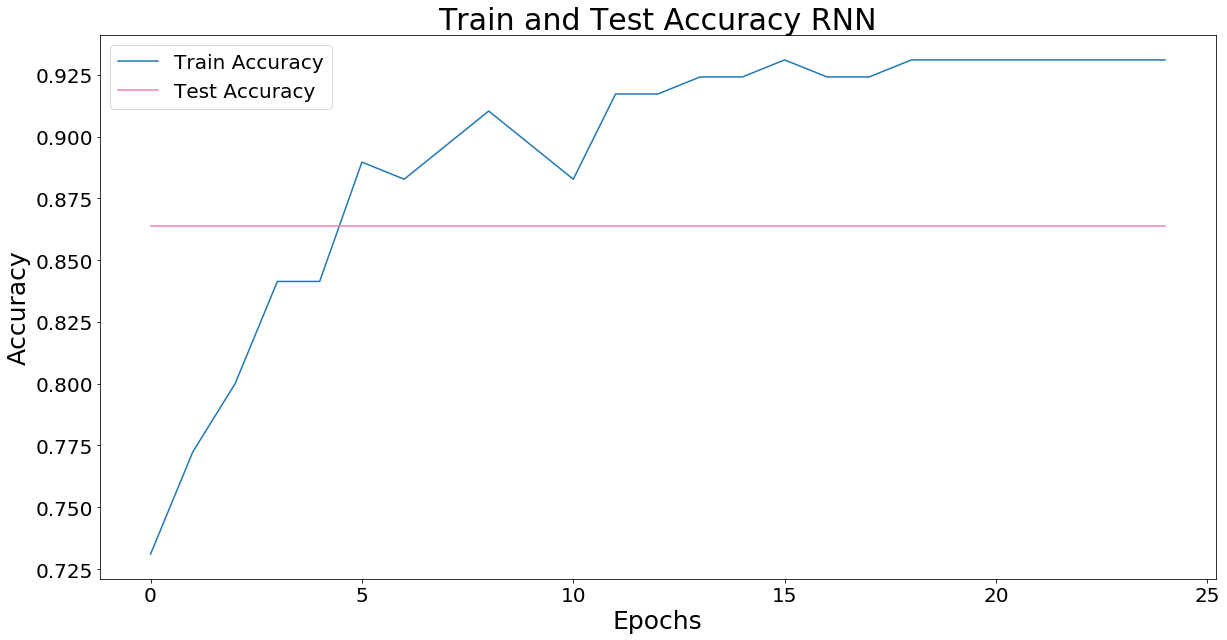

In [288]:
plt.figure(figsize = (20,10))
plt.title('Train and Test Accuracy RNN', fontsize = 30)
plt.plot(history.history['acc'], label = 'Train Accuracy', c = 'C0')
plt.plot(history.history['val_acc'], label = 'Test Accuracy', c = '#E983BD')
plt.xlabel('Epochs', fontsize = 25)
plt.ylabel('Accuracy', fontsize = 25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 20);

We can see that the testing accuracy hits its peak almost immediately, while the training accuracy hits a local maximum, then dips, reaches its maximum, and then settles right around 94%. 

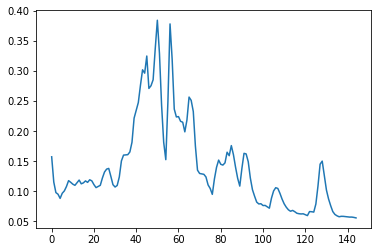

In [289]:
plt.plot(model.predict_generator(train_sequences)[:,0])

Looking at the predictive probabilities, we can see that they never reach .5, which means it never predicts that a patch will be released. It gets close, but ultimately there isn't enough signal to push it past the 50% probability mark. The strongest signal is up until 60 days, when it drops off significantly and the model begins to break down. 

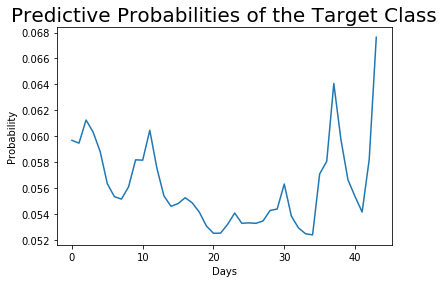

In [290]:
plt.title('Predictive Probabilities of the Target Class', fontsize = 20)
plt.xlabel('Days', fontsize = 10)
plt.ylabel('Probability', fontsize = 10)
plt.plot(model.predict_generator(test_sequences)[:,0])
plt.savefig('../plots/predictive_probabilities_rnn')

Looking at the predictive probabilities of the validation set, we see that they never pass .4, which means there is no way it is predicting a patch release, as it never passes 50%. This is a frustrating realization that there really isn't enough signal in the dataset to produce anything but a null result. 

In [291]:
model.predict_generator(test_sequences)[:,0]

array([0.05969679, 0.05948058, 0.0612618 , 0.06032544, 0.0588153 ,
       0.05635974, 0.05535999, 0.05517122, 0.05611095, 0.05819571,
       0.05816895, 0.06047001, 0.05756786, 0.05541807, 0.05461794,
       0.05482566, 0.05527771, 0.05488196, 0.05416727, 0.05309647,
       0.05253941, 0.05254892, 0.05322841, 0.05409935, 0.05331025,
       0.05334052, 0.05330551, 0.05348998, 0.05429769, 0.054407  ,
       0.05633199, 0.053864  , 0.05295694, 0.05250579, 0.05241349,
       0.05710581, 0.05808187, 0.06407392, 0.05977532, 0.05665714,
       0.05536965, 0.05417676, 0.05821732, 0.0676359 ], dtype=float32)

Above we can see the probabilities of the test_sequence. Most of them sit between .37 and .39, but none of them pass the threshold. 

## RNN without OP Words

In [292]:
op_list = [' op', 'nerf', 'perk', 
           'over', 'weak', 'too', 
           'hax', 'pass', 'rage', 
           'spray', 'power', 'buff', 
           'o p', 'strong', 'snipe', 
           'impossible', 'hack', 'need', 
           'quit', 'auto', 'noob',
           'range', 'rate', 'fire']

In [293]:
X = df_daily.drop(columns = ['patch_update', 'created_utc',' op', 'nerf', 'perk', 
                             'over', 'weak', 'too', 
                             'hax', 'pass', 'rage', 
                             'spray', 'power', 'buff', 
                             'o p', 'strong', 'snipe', 
                             'impossible', 'hack', 'need', 
                             'quit', 'auto', 'noob',
                             'range', 'rate', 'fire', 'count_comments', 'body'
                             ])
X.head()

,score,compound,character_count,word_count,interaction_score_compound,compound_sum,unique_authors,interaction_sum,comment_count
date,,,,,,,,,
2018-10-11,44081,0.179693,1358543.0,256354,0.603192,2051.7369,4237,6887.2453,11418
2018-10-12,70759,0.143451,2415905.0,454034,0.511025,2741.9244,8202,9767.7377,19114
2018-10-13,66467,0.095393,2288630.0,431604,0.229019,1496.5304,7089,3592.8498,15688
2018-10-14,65811,0.078420,2568833.0,484629,0.171104,1350.9338,7771,2947.6086,17227
2018-10-15,79944,0.079358,3053849.0,575691,0.115871,1573.1210,8220,2296.9086,19823


In [294]:
y = df_daily['patch_update']

In [295]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    shuffle = False,
                                                    random_state = 13)

In [296]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

/Users/adamburpee/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/adamburpee/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/adamburpee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [297]:
train_sequences = TimeseriesGenerator(X_train_sc,
                                      y_train,
                                      length = 1,
                                      batch_size = 25)

In [298]:
test_sequences = TimeseriesGenerator(X_test_sc, 
                                     y_test,
                                     length = 1,
                                     batch_size = 25)

In [299]:
X_train.shape

(152, 9)

In [300]:
model = Sequential()


In [301]:
model.add(GRU(32,
              input_shape = (1,9),
              return_sequences = True))

model.add(GRU(36,
              return_sequences = False))

# model.add(GRU(18,
#               return_sequences = False))

model.add(Dense(16,
                activation = 'relu'))

model.add(Dropout(0.5))

model.add(Dense(16,
                activation = 'relu'))

#model.add(Dropout(0.5))

model.add(Dense(1,
                activation = 'sigmoid'))

In [302]:
model.compile(loss = 'binary_crossentropy',
#               optimizer = 'sgd',
              optimizer = Adam(lr = .0006),
              metrics = ['accuracy'])

In [303]:
history = model.fit_generator(train_sequences,
                              epochs = 20,
                              validation_data = test_sequences,
                              verbose = 1)

Epoch 1/20
7/7 [==============================] - 7s 951ms/step - loss: 0.7104 - acc: 0.2040 - val_loss: 0.6953 - val_acc: 0.2400
Epoch 2/20
7/7 [==============================] - 0s 5ms/step - loss: 0.6944 - acc: 0.5862 - val_loss: 0.6834 - val_acc: 0.8600
Epoch 3/20
7/7 [==============================] - 0s 17ms/step - loss: 0.6840 - acc: 0.8485 - val_loss: 0.6772 - val_acc: 0.8600
Epoch 4/20
7/7 [==============================] - 0s 15ms/step - loss: 0.6731 - acc: 0.8893 - val_loss: 0.6713 - val_acc: 0.8600
Epoch 5/20
7/7 [==============================] - 0s 14ms/step - loss: 0.6623 - acc: 0.9359 - val_loss: 0.6657 - val_acc: 0.8600
Epoch 6/20
7/7 [==============================] - 0s 15ms/step - loss: 0.6510 - acc: 0.9417 - val_loss: 0.6594 - val_acc: 0.8600
Epoch 7/20
7/7 [==============================] - 0s 14ms/step - loss: 0.6428 - acc: 0.9417 - val_loss: 0.6533 - val_acc: 0.8600
Epoch 8/20
7/7 [==============================] - 0s 15ms/step - loss: 0.6336 - acc: 0.9417 - val

Plotting the Accuracy of my RNN model in predicting Patch Dates.

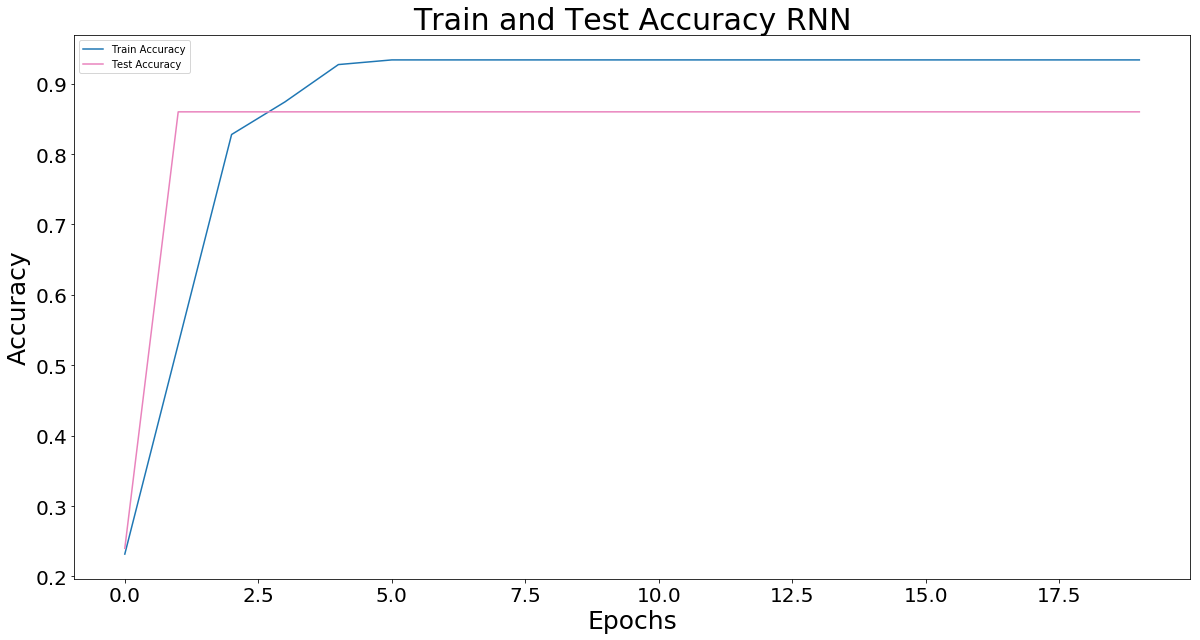

In [304]:
plt.figure(figsize = (20,10))
plt.title('Train and Test Accuracy RNN', fontsize = 30)
plt.plot(history.history['acc'], label = 'Train Accuracy', c = 'C0')
plt.plot(history.history['val_acc'], label = 'Test Accuracy', c = '#E983BD')
plt.xlabel('Epochs', fontsize = 25)
plt.ylabel('Accuracy', fontsize = 25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend();

In [305]:
y_train.value_counts(normalize= True)

0.0    0.934211
1.0    0.065789
Name: patch_update, dtype: float64

In [306]:
y_test.value_counts(normalize = True)

0.0    0.843137
1.0    0.156863
Name: patch_update, dtype: float64

This RNN model utilized just the reddit meta data, comment count, word count, character count, score, sentiment, etc. and scored about the same in terms of accuracy as the model that utilized specific words that I picked. It scored 86% accuracy on the validation set and 94% accuracy on the training set. 

It turns out that the words I picked, or any specific word usage, may not have a direct impact on the model's accuracy. This may be due to a few things. As seen in the previous notebook, the frequency of words I picked dropped off as the dataset approached the present day, so their weight in the overall dataset may not be as strong as I previously thought. Additionally, spikes in specific words may happen randomly, dependent on the user base on any given day, as opposed to the meta data that follows pretty consistent trends. 

I will run another RNN on a PCA-ed dataset of all of the 2000 words my countvectorizer produced.

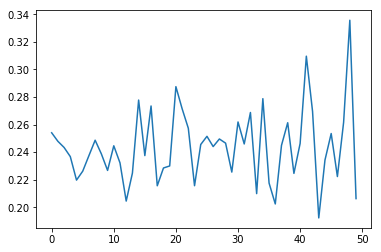

In [307]:
plt.plot(model.predict_generator(test_sequences)[:,0])

In [308]:
model.predict_generator(test_sequences)[:,0]

array([0.2540355 , 0.24784774, 0.24336669, 0.23674151, 0.21969157,
       0.22616115, 0.2374666 , 0.24863684, 0.23870513, 0.22671369,
       0.24458331, 0.23218107, 0.20446771, 0.22476569, 0.27777296,
       0.23746967, 0.27347377, 0.2155726 , 0.22847626, 0.2299596 ,
       0.2875073 , 0.27152884, 0.25730333, 0.21561772, 0.24553429,
       0.25145537, 0.24401733, 0.24952817, 0.24650726, 0.22551033,
       0.2618701 , 0.2459265 , 0.26874816, 0.20987621, 0.27878928,
       0.21752438, 0.20238078, 0.24490437, 0.26132137, 0.22456267,
       0.24629325, 0.30961925, 0.26956928, 0.19224134, 0.2342386 ,
       0.25348404, 0.2222648 , 0.26160222, 0.3357051 , 0.20625064],
      dtype=float32)

Looking at the probabilities above, we can see that they get right up to 40%, but still don't pass the 50% threshold, which means they won't ever predict that a patch is beign released. This is a similar result to the model with the OP words.

## RNN with PCA on CVEC

In [309]:
X = df_daily.drop([' op', 'nerf', 'perk', 
                  'over', 'weak', 'too', 
                  'hax', 'pass', 'rage', 
                  'spray', 'power', 'buff', 
                  'o p', 'strong', 'snipe', 
                  'impossible', 'hack', 'need', 
                  'quit', 'auto', 'noob',
                  'range', 'rate', 'fire', 
                  'count_comments', 'patch_update',
                  'created_utc', 'body'
                             ], axis = 1)

Merging my cvec df with my daily df.

In [310]:
X = X.merge(df_most_common_words, left_index=True, right_index = True)

In [311]:
y = df_daily['patch_update']

In [312]:
from sklearn.decomposition import PCA

In [313]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    shuffle = False,
                                                    )

Scaling my training and test sets.

In [314]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

/Users/adamburpee/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/adamburpee/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/adamburpee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


Instantiating my PCA with 20 components. 

In [315]:
pca = PCA(n_components = 20)
pca.fit(X_train_sc)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Examining my components. 

In [316]:
pca.components_

array([[ 2.48889042e-02, -1.21578467e-02,  3.33989351e-02, ...,
         7.16924883e-03,  5.96347359e-03,  2.08621250e-02],
       [-3.24632764e-02,  1.01476466e-02,  7.25422593e-04, ...,
         1.10703358e-02,  3.13092979e-02, -1.28230609e-02],
       [ 4.34693545e-02,  7.40173138e-02,  7.42322208e-04, ...,
         2.72471148e-02,  3.62246344e-02,  5.41216013e-02],
       ...,
       [-2.12846661e-02, -6.01036085e-03,  2.28873849e-03, ...,
         8.42855560e-03,  1.16001601e-02, -4.03454294e-02],
       [ 1.44052526e-02, -5.11412487e-03, -1.78509609e-05, ...,
        -2.94556550e-03, -1.28928109e-02,  2.97345761e-02],
       [-9.37229899e-03, -1.28756745e-02, -1.38149689e-03, ...,
        -2.28678969e-02,  1.20970897e-02,  3.55754266e-02]])

In [317]:
var_exp = pca.explained_variance_ratio_
var_exp

array([0.44483628, 0.05915914, 0.03132038, 0.01886472, 0.01236938,
       0.01148676, 0.01104043, 0.0099533 , 0.00976506, 0.00905802,
       0.00801758, 0.00752132, 0.00716631, 0.00681777, 0.00655536,
       0.00644512, 0.00618837, 0.00598196, 0.00578216, 0.00565036])

As seen above, close to zero variance is explained by most of my components. The first component is the only one that explains a good amount of variance, at 44%. 

Setting up my new components that I will use in the model. 

In [318]:
Z_train = pca.transform(X_train_sc)

In [319]:
Z_test = pca.transform(X_test_sc)

In [320]:
train_sequences = TimeseriesGenerator(Z_train,
                                      y_train,
                                      length = 7,
                                      batch_size = 50)

In [321]:
test_sequences = TimeseriesGenerator(Z_test, 
                                     y_test,
                                     length = 7,
                                     batch_size = 50)

In [322]:
Z_train.shape

(152, 20)

In [323]:
model = Sequential()


In [324]:
model.add(GRU(32,
              input_shape = (7,20),
              return_sequences = True))

model.add(LSTM(36,
              return_sequences = True))

model.add(GRU(18,
              return_sequences = False))

model.add(Dense(16,
                activation = 'relu'))



model.add(Dropout(0.5))

model.add(Dense(16,
                activation = 'relu'))

#model.add(Dropout(0.5))

model.add(Dense(1,
                activation = 'sigmoid'))

In [325]:
model.compile(loss = 'binary_crossentropy',
#               optimizer = 'sgd',
              optimizer = Adam(lr = .0006),
              metrics = ['accuracy'])

In [326]:
history = model.fit_generator(train_sequences,
                              epochs = 30,
                              validation_data = test_sequences,
                              verbose = 1)

Epoch 1/30
3/3 [==============================] - 7s 2s/step - loss: 0.6656 - acc: 0.6017 - val_loss: 0.6600 - val_acc: 0.8636
Epoch 2/30
3/3 [==============================] - 0s 20ms/step - loss: 0.6496 - acc: 0.7120 - val_loss: 0.6412 - val_acc: 0.8636
Epoch 3/30
3/3 [==============================] - 0s 43ms/step - loss: 0.6213 - acc: 0.8151 - val_loss: 0.6217 - val_acc: 0.8636
Epoch 4/30
3/3 [==============================] - 0s 32ms/step - loss: 0.6020 - acc: 0.8773 - val_loss: 0.6041 - val_acc: 0.8636
Epoch 5/30
3/3 [==============================] - 0s 36ms/step - loss: 0.5773 - acc: 0.9031 - val_loss: 0.5887 - val_acc: 0.8636
Epoch 6/30
3/3 [==============================] - 0s 34ms/step - loss: 0.5648 - acc: 0.9115 - val_loss: 0.5711 - val_acc: 0.8636
Epoch 7/30
3/3 [==============================] - 0s 36ms/step - loss: 0.5467 - acc: 0.9316 - val_loss: 0.5524 - val_acc: 0.8636
Epoch 8/30
3/3 [==============================] - 0s 35ms/step - loss: 0.5058 - acc: 0.9316 - val_l

Plotting the Accuracy of my RNN model in predicting Patch Dates.

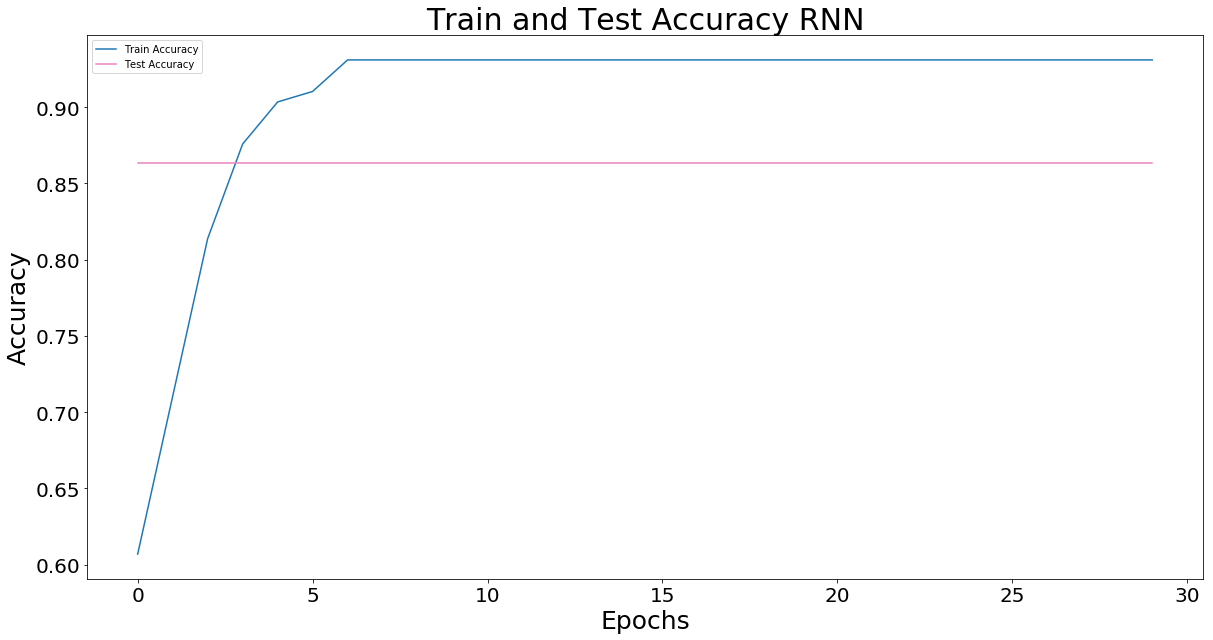

In [327]:
plt.figure(figsize = (20,10))
plt.title('Train and Test Accuracy RNN', fontsize = 30)
plt.plot(history.history['acc'], label = 'Train Accuracy', c = 'C0')
plt.plot(history.history['val_acc'], label = 'Test Accuracy', c = '#E983BD')
plt.xlabel('Epochs', fontsize = 25)
plt.ylabel('Accuracy', fontsize = 25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend();
plt.savefig('../plots/rnn_train_test_accuracy')

As we can see above, the accuracy scored by my PCA components is about the same as the accuracy of my dataset with my choice of words, as well as the dataset with no NLP data. I think this shows that most of the information gain in my RNN model is gathered from the meta data, such as comment count, sentiment, word count, reddit score, etc. As much as I'd like to say that I am satisfied with these results, I can't. This is showing that the individual word usage isn't playing a big part in predicting patches, which might mean that as the topics of discussion change over time, the frequency of new (or old) words don't hold much predictive power. As a whole, the meta data on its own or combined with NLP doesn't really have a lot of predictive power on patch days. 

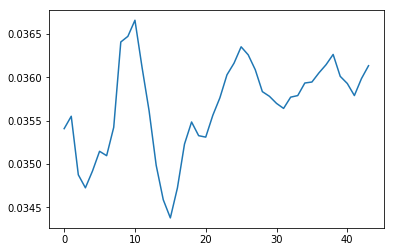

In [328]:
plt.plot(model.predict_generator(test_sequences)[:,0])


In [329]:
model.predict_generator(test_sequences)[:,0]

array([0.03540704, 0.03555009, 0.03487486, 0.03472501, 0.03491819,
       0.035146  , 0.03509554, 0.03542179, 0.03640628, 0.03647122,
       0.03665701, 0.03611559, 0.03561172, 0.03498438, 0.03458765,
       0.03437793, 0.03472376, 0.03522947, 0.03548396, 0.03532597,
       0.03530949, 0.03556085, 0.03576279, 0.03602755, 0.03616247,
       0.03635079, 0.03625816, 0.03608617, 0.03583387, 0.03578001,
       0.03569841, 0.03564048, 0.03577036, 0.03578851, 0.03593338,
       0.0359447 , 0.03605077, 0.03614452, 0.03626257, 0.03601041,
       0.03592788, 0.03578866, 0.03598395, 0.03613291], dtype=float32)

As we can see above, the highest probability is .09, which is nowhere close to 50%, suggesting that my components aren't gathering a lot of signal. 

# Conclusion and Next Steps

Contrary to my initial assumption that the RNN model would be able to pick up signal and predict patch dates with some certainty and accuracy, it did not. I attempted RNN with three different variations of the same dataset, one with my OP list, one without my OP list and just the reddit meta data and binned data that I created, and one on which I ran Principal Component Analysis to extract features instead of remove them.  There are a few reasons that I think have had a significant effect on my project as a whole. 

1. I pulled a ton of data, 2 million comments. However, after grouping by date, my dataset shrunk to 203 rows, with only 18 targets, which is less than 10%. This turned out to be quite a small dataset to be working with. Using aggregate data did not work as well as I had hoped. 

I think for this to be a fruitful examination of user sentiment, I will have to collect data over a much longer time period, or collect data on all of the light fixes as well, and include those as targets. Smaller fixes are common but not well documented, which makes it difficult to find all of them. The actual numbered patches that are significant and take time to download are the ones that are well documented. 

2. Reddit use is not directly related to videogame use. Users could pop up online on reddit for a day or two and spread their hate or love for the game without that sentiment having an impact on whether or not they play the game. 

Personally,  I've complained about the game and shared negative sentiment, but that didn't stop me from turning my playstation back on and continuing to play for 4 hours straight. 

3. Trying to find words that are strictly associated with negative sentiment proved to be difficult. The comments ranged from 3 to 2000 words, and finding the sentiment of the overall comment may not have worked as well as I had hoped. I attempted to search for keywords that I associated with things people complain about the game, but as user activity decreases on reddit and updates are made to the game, those comments go down. 

When I vectorized without setting the max features, my unique words were up to the number of words in the English language, due to typos, jargon, and general internet speak. While 2000 is a lot of words, I think it definitely would have been beneficial to be able to use the full corpus. 

With all of this in mind, I don't think videogame companies, specifically Activision in this case, should take user feedback into account when developing patches. The overall sentiment of users is so fleeting that no matter what the change, there will be people that despise it and people that love it. That being said, there are aspects of the game that 'break', and when things like that come up, I think Activision should pay attention to those comments. The measurement for success or satisfaction should not be in the hands of the online community. Similar to yelp, there are so few people that actually play AND participate in online feedback that it may be futile to try to observe user feedback. 

In the next notebook I explore will user churn from reddit, and how sentiment plays a part in that.